In [1]:
from matplotlib import pyplot as plt
from tqdm.autonotebook import tqdm

import torch
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from gluonts.dataset.repository.datasets import get_dataset

from gluonts.dataset.pandas import PandasDataset
import pandas as pd

from lag_llama.gluon.estimator import LagLlamaEstimator
import yfinance as yf

from gluonts.model.predictor import Predictor
from pathlib import Path

import optuna
import lightning
import os


/tmp/ipykernel_4626/1689063584.py:2: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm
/home/rynowak/Dokumenty/Programy/EksploracjaDanych/EksploracjaDanych/env_ll/lib/python3.10/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


In [2]:
os.environ['TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD'] = '1'

In [3]:
eqr = yf.Ticker("EQR")
df = eqr.history(period="max")
df = df[['Close']]  

df.reset_index(inplace=True)
df.rename(columns={"Date": "date", "Close": "value"}, inplace=True)
df['date'] = pd.to_datetime(df['date'])
df['value'] = df['value'].astype('float32')

df.set_index("date", inplace=True)
full_index = pd.date_range(start=df.index.min(), end=df.index.max(), freq='d')

df = df.reindex(full_index)

df.fillna(method='ffill', inplace=True)

df.head()

/tmp/ipykernel_4626/2354060357.py:15: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


,value
1993-08-12 00:00:00-04:00,2.754306
1993-08-13 00:00:00-04:00,2.670114
1993-08-14 00:00:00-04:00,2.670114
1993-08-15 00:00:00-04:00,2.670114
1993-08-16 00:00:00-04:00,2.694169


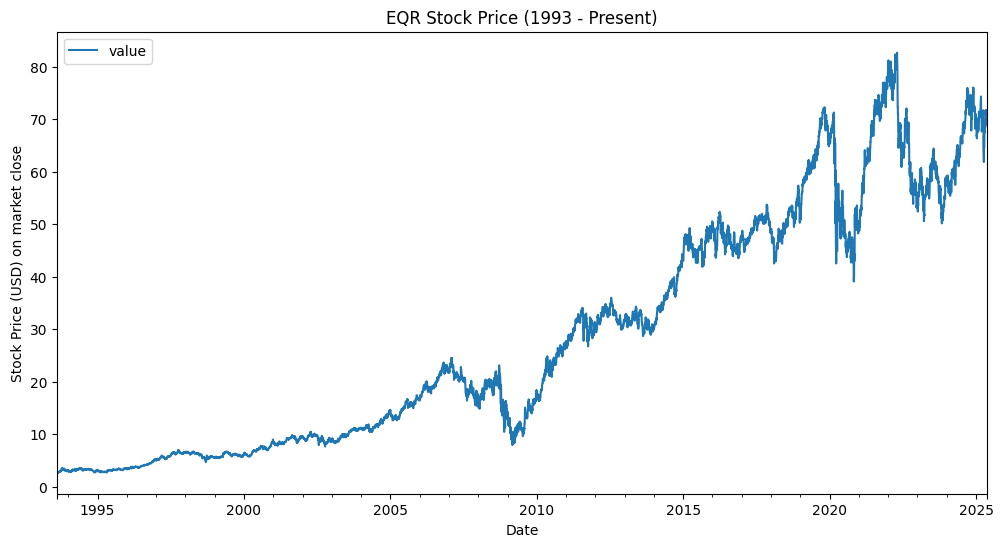

(11601, 1)


In [4]:
df.plot(title='EQR Stock Price (1993 - Present)', figsize=(12, 6))
plt.xlabel('Date')
plt.ylabel('Stock Price (USD) on market close')
plt.show()
print(df.shape)

In [5]:
train_end = round(len(df) * 0.7)
valid_end = round(len(df) * 0.9)

train = PandasDataset(df[:train_end], freq="d", target="value")
valid = PandasDataset(df[train_end:valid_end], freq="d", target="value")
test = PandasDataset(df[valid_end:], freq="d", target="value")

In [6]:
prediction_length = 7
context_length = prediction_length * 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
default_estimator = LagLlamaEstimator(
    prediction_length=prediction_length,
    context_length=context_length,
    device=device,
    trainer_kwargs = {"max_epochs": 50}
)

In [8]:
if Path("default_model").exists():
    default_predictor = Predictor.deserialize(Path("default_model"))
else:
    default_predictor = default_estimator.train(train, valid)
    Path("default_model").mkdir(parents=True, exist_ok=True)
    default_predictor.serialize(Path("default_model"))

/home/rynowak/Dokumenty/Programy/EksploracjaDanych/EksploracjaDanych/env_ll/lib/python3.10/site-packages/gluonts/torch/model/predictor.py:117: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  state_dict = torch.load(


In [9]:
test_periods = pd.date_range(df[valid_end:].index[60], periods=9, freq="7d").tolist()
print(test_periods)

[Timestamp('2022-05-13 00:00:00-0400', tz='America/New_York'), Timestamp('2022-05-20 00:00:00-0400', tz='America/New_York'), Timestamp('2022-05-27 00:00:00-0400', tz='America/New_York'), Timestamp('2022-06-03 00:00:00-0400', tz='America/New_York'), Timestamp('2022-06-10 00:00:00-0400', tz='America/New_York'), Timestamp('2022-06-17 00:00:00-0400', tz='America/New_York'), Timestamp('2022-06-24 00:00:00-0400', tz='America/New_York'), Timestamp('2022-07-01 00:00:00-0400', tz='America/New_York'), Timestamp('2022-07-08 00:00:00-0400', tz='America/New_York')]


In [10]:
forecasts = []
groundtruths = []
for period_start in test_periods:
    forecast_it, ts_it = make_evaluation_predictions(
        dataset=PandasDataset(df[:period_start], freq="d", target="value"),
        predictor=default_predictor,
    )
    forecasts.append(list(forecast_it))
    groundtruths.append(list(ts_it))

/home/rynowak/Dokumenty/Programy/EksploracjaDanych/EksploracjaDanych/env_ll/lib/python3.10/site-packages/gluonts/dataset/pandas.py:174: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df = df.to_period(freq=self.freq)
/home/rynowak/Dokumenty/Programy/EksploracjaDanych/EksploracjaDanych/env_ll/lib/python3.10/site-packages/gluonts/dataset/pandas.py:174: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df = df.to_period(freq=self.freq)
/home/rynowak/Dokumenty/Programy/EksploracjaDanych/EksploracjaDanych/env_ll/lib/python3.10/site-packages/gluonts/dataset/pandas.py:174: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df = df.to_period(freq=self.freq)
/home/rynowak/Dokumenty/Programy/EksploracjaDanych/EksploracjaDanych/env_ll/lib/python3.10/site-packages/gluonts/dataset/pandas.py:174: UserWarning: Converting to PeriodArray/Index representation will drop ti

In [11]:
evaluator = Evaluator()
scores = [] 
for (true_series, forecast) in zip(groundtruths, forecasts):
    _, metrics_df = evaluator(true_series, forecast)
    scores.append(metrics_df)

Running evaluation: 1it [00:00, 20.20it/s]
Running evaluation: 1it [00:00, 23.63it/s]
Running evaluation: 1it [00:00, 20.03it/s]
Running evaluation: 1it [00:00, 20.75it/s]
Running evaluation: 1it [00:00, 24.41it/s]
Running evaluation: 1it [00:00, 27.32it/s]
Running evaluation: 1it [00:00, 27.36it/s]
Running evaluation: 1it [00:00, 26.12it/s]
Running evaluation: 1it [00:00, 28.57it/s]


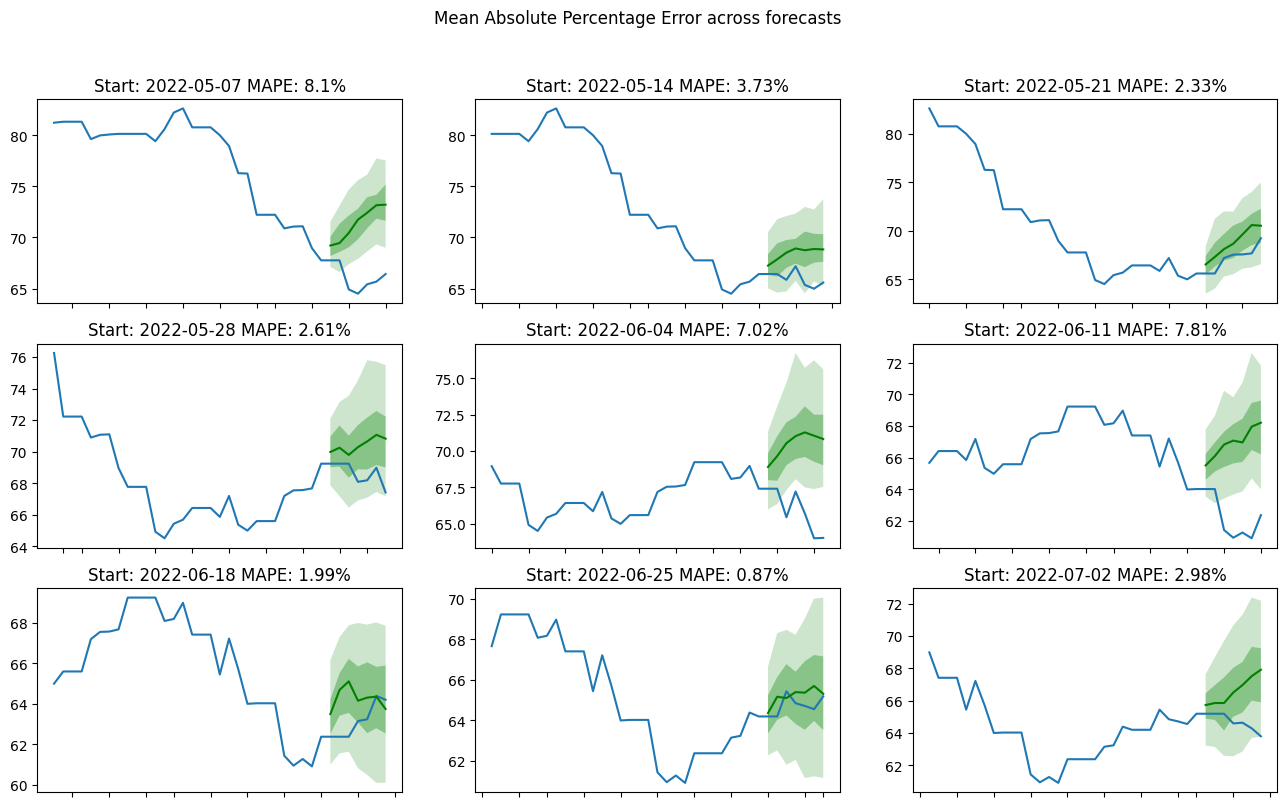

Average MAPE: 4.16


In [12]:
plt.figure(figsize=(16, 9))
mape_scores = []
for idx in range(len(forecasts)):
    ax = plt.subplot(3, 3, idx + 1)
    true_series = groundtruths[idx][0][
        forecasts[idx][0].start_date.to_timestamp() - pd.Timedelta(days=30) :
    ]
    mape_score = float(f'{scores[idx]["MAPE"][0]:.4f}') * 100.0
    mape_score = float(f"{mape_score:.2f}")
    mape_scores.append(mape_score)
    ax.set_title(
        "Start: "
        + str(scores[idx]["forecast_start"][0])
        + " MAPE: "
        + str(mape_score)
        + "%"
    )
    plt.plot(true_series.index.to_timestamp(), true_series[0])
    ax.set_xticklabels([])
    forecasts[idx][0].plot(color="g")

plt.suptitle("Mean Absolute Percentage Error across forecasts")
plt.show()
print(f"Average MAPE: {sum(mape_scores) / len(mape_scores):.2f}")

In [13]:
best_score = float("inf")
evaluator = Evaluator()

def objective(trial):
    global best_score
    config = {
        "input_size": trial.suggest_categorical("input_size", [1, 2, 4]),
        "n_layer": trial.suggest_int("n_layer", 1, 8),
        "n_embd_per_head": trial.suggest_categorical("n_embd_per_head", [16, 32, 64]),
        "n_head": trial.suggest_categorical("n_head", [2, 4, 8]),
        # "time_feat": trial.suggest_categorical("time_feat", [True, False]),
        "batch_size": trial.suggest_categorical("batch_size", [16, 32, 64]),
        "lr": trial.suggest_float("lr", 1e-5, 1e-2, log=True),
        "weight_decay": trial.suggest_float("weight_decay", 1e-10, 1e-5, log=True),
    }
    estimator = LagLlamaEstimator(
        prediction_length=prediction_length,
        context_length=context_length,
        device=device,
        trainer_kwargs = {"max_epochs": 30},
        **config
    )
    try:
        predictor = estimator.train(train, valid)
        forecast_it, ts_it = make_evaluation_predictions(valid, predictor)
        agg_metrics, _ = evaluator(ts_it, forecast_it)
        mape = agg_metrics["MAPE"]
        if mape < best_score:
            best_score = mape
            print(f"New best MAPE: {mape:.4f}, saving model...")
            Path("best_model").mkdir(parents=True, exist_ok=True)
            predictor.serialize(Path("best_model"))

        return mape

    except Exception as e:
        print(f"Trial failed: {e}")
        return float("inf")

In [14]:
study = optuna.create_study(study_name="lag_llama_tune", storage="sqlite:///optuna.db", direction="minimize", load_if_exists=True)
if not Path("optuna.db").exists():
    study.optimize(objective, n_trials=30, timeout=3600)

print(study.best_params)
print(study.best_value)

[I 2025-05-19 14:34:25,293] Using an existing study with name 'lag_llama_tune' instead of creating a new one.


{'input_size': 1, 'n_layer': 4, 'n_embd_per_head': 16, 'n_head': 8, 'time_feat': True, 'batch_size': 32, 'lr': 2.7744644088469602e-05, 'weight_decay': 3.36809426519071e-10}
0.005752560815640858


In [15]:
best_predictor = Predictor.deserialize(Path("best_model"))

/home/rynowak/Dokumenty/Programy/EksploracjaDanych/EksploracjaDanych/env_ll/lib/python3.10/site-packages/gluonts/torch/model/predictor.py:117: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  state_dict = torch.load(


In [16]:
import lightning.pytorch


params = study.best_params
params.update(
    {
        "time_feat": False,
    }
)

if Path("best_model_trained").exists():
    best_predictor = Predictor.deserialize(Path("best_model_trained"))
else:
    best_estimator = LagLlamaEstimator(
        prediction_length=prediction_length,
        context_length=context_length,
        device=device,
        trainer_kwargs={
            "max_epochs": 200,
            "callbacks": [
                lightning.pytorch.callbacks.EarlyStopping(
                    monitor="val_loss", patience=50
                )
            ],
        },
        **params,
    )
    best_predictor = best_estimator.train(train, valid)
    Path("best_model_trained").mkdir(parents=True, exist_ok=True)
    best_predictor.serialize(Path("best_model_trained"))

/home/rynowak/Dokumenty/Programy/EksploracjaDanych/EksploracjaDanych/env_ll/lib/python3.10/site-packages/gluonts/dataset/pandas.py:174: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df = df.to_period(freq=self.freq)
/home/rynowak/Dokumenty/Programy/EksploracjaDanych/EksploracjaDanych/env_ll/lib/python3.10/site-packages/gluonts/dataset/pandas.py:174: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df = df.to_period(freq=self.freq)
/home/rynowak/Dokumenty/Programy/EksploracjaDanych/EksploracjaDanych/env_ll/lib/python3.10/site-packages/gluonts/dataset/pandas.py:174: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df = df.to_period(freq=self.freq)
/home/rynowak/Dokumenty/Programy/EksploracjaDanych/EksploracjaDanych/env_ll/lib/python3.10/site-packages/gluonts/dataset/pandas.py:174: UserWarning: Converting to PeriodArray/Index representation will drop ti

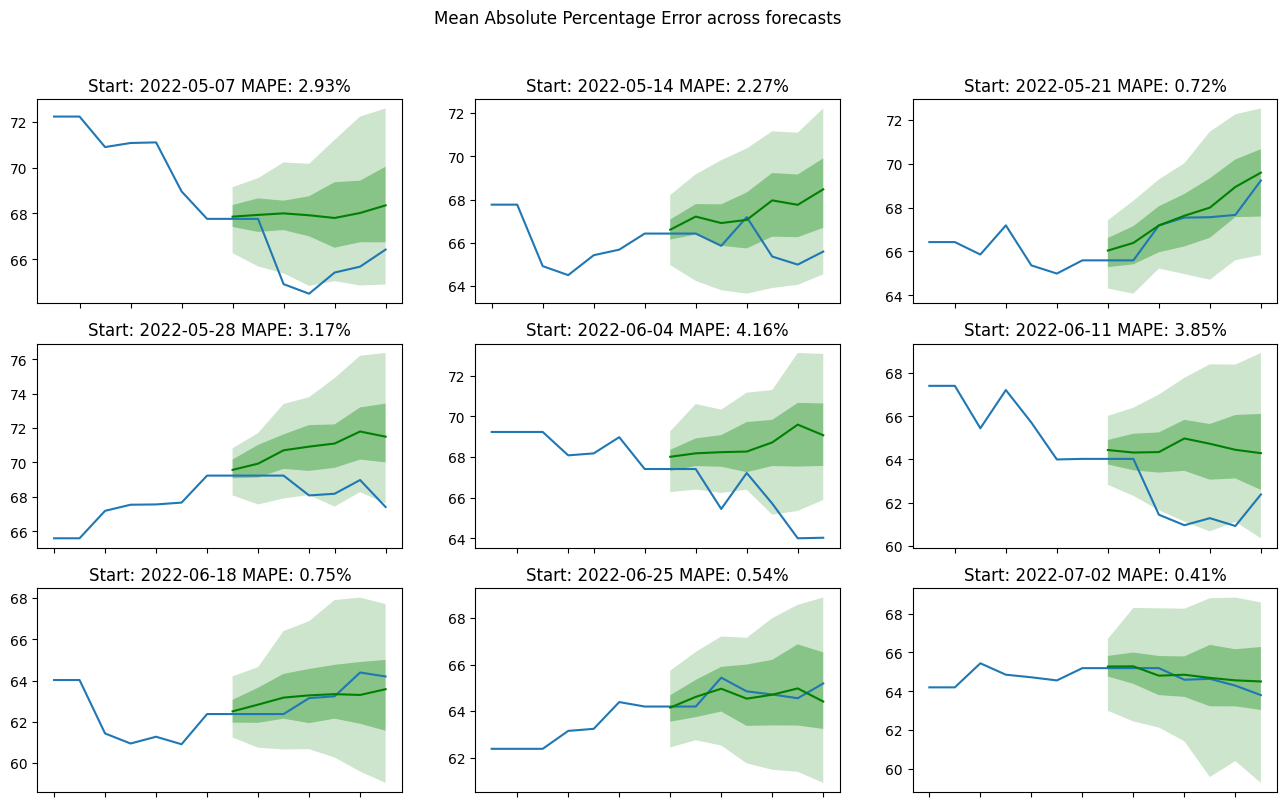

Average MAPE: 2.09


In [17]:
forecasts = []
groundtruths = []
for period_start in test_periods:
    forecast_it, ts_it = make_evaluation_predictions(
        dataset=PandasDataset(df[:period_start], freq="d", target="value"),
        predictor=best_predictor,
    )
    forecasts.append(list(forecast_it))
    groundtruths.append(list(ts_it))

evaluator = Evaluator()
scores = [] 
for (true_series, forecast) in zip(groundtruths, forecasts):
    _, metrics_df = evaluator(true_series, forecast)
    scores.append(metrics_df)

plt.figure(figsize=(16, 9))
mape_scores = []
for idx in range(len(forecasts)):
    ax = plt.subplot(3, 3, idx + 1)
    true_series = groundtruths[idx][0][
        forecasts[idx][0].start_date.to_timestamp() - pd.Timedelta(days=7) :
    ]
    mape_score = float(f'{scores[idx]["MAPE"][0]:.4f}') * 100.0
    mape_score = float(f"{mape_score:.2f}")
    mape_scores.append(mape_score)
    ax.set_title(
        "Start: "
        + str(scores[idx]["forecast_start"][0])
        + " MAPE: "
        + str(mape_score)
        + "%"
    )
    plt.plot(true_series.index.to_timestamp(), true_series[0])
    ax.set_xticklabels([])
    forecasts[idx][0].plot(color="g")

plt.suptitle("Mean Absolute Percentage Error across forecasts")
plt.show()
print(f"Average MAPE: {sum(mape_scores) / len(mape_scores):.2f}")

/tmp/ipykernel_4626/595069674.py:12: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  plt.plot(true_series.index.to_timestamp(), true_series[0])


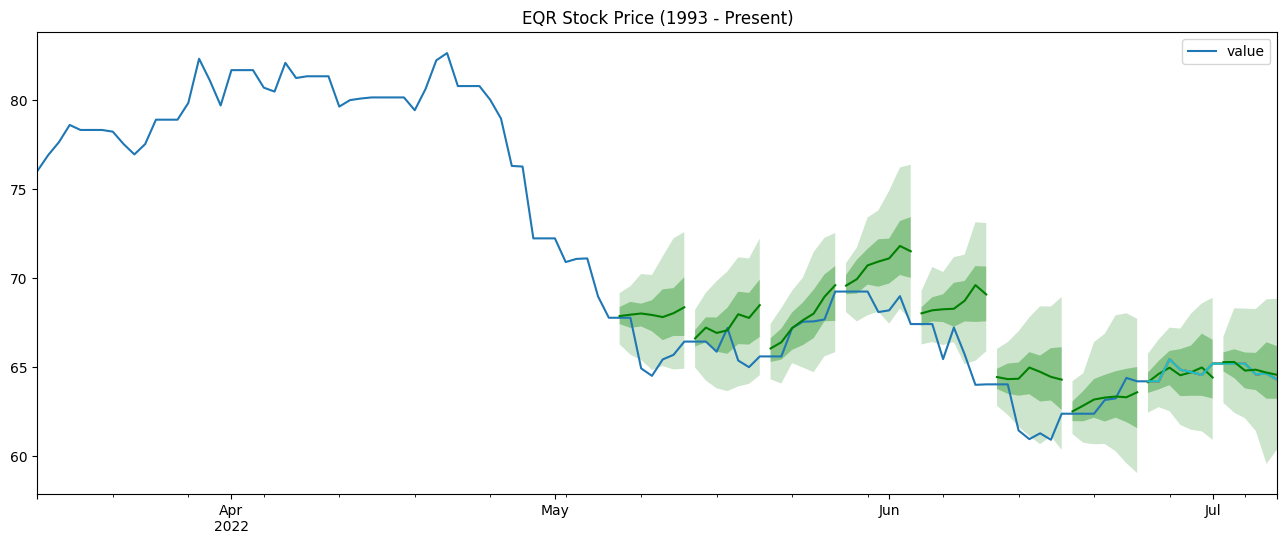

In [ ]:
mape_scores = []
df[valid_end: valid_end + 60 + 7*8].plot(title='EQR Stock Price (1993 - Present)', figsize=(16, 6))
for idx in range(len(forecasts)):
    mape_score = float(f'{scores[idx]["MAPE"][0]:.4f}') * 100.0
    mape_score = float(f"{mape_score:.2f}")
    mape_scores.append(mape_score)
    plt.plot(true_series.index.to_timestamp(), true_series[0])
    forecasts[idx][0].plot(color="g")
